# MNIST : CNN Example

In [ ]:
!pip install torchinfo
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torchvision  import models
from   torchinfo    import summary  

## MNIST dataset

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor 
trn_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
tst_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

trn: torch.Size([60000, 28, 28]) torch.Size([60000])
tst: torch.Size([10000, 28, 28]) torch.Size([10000])


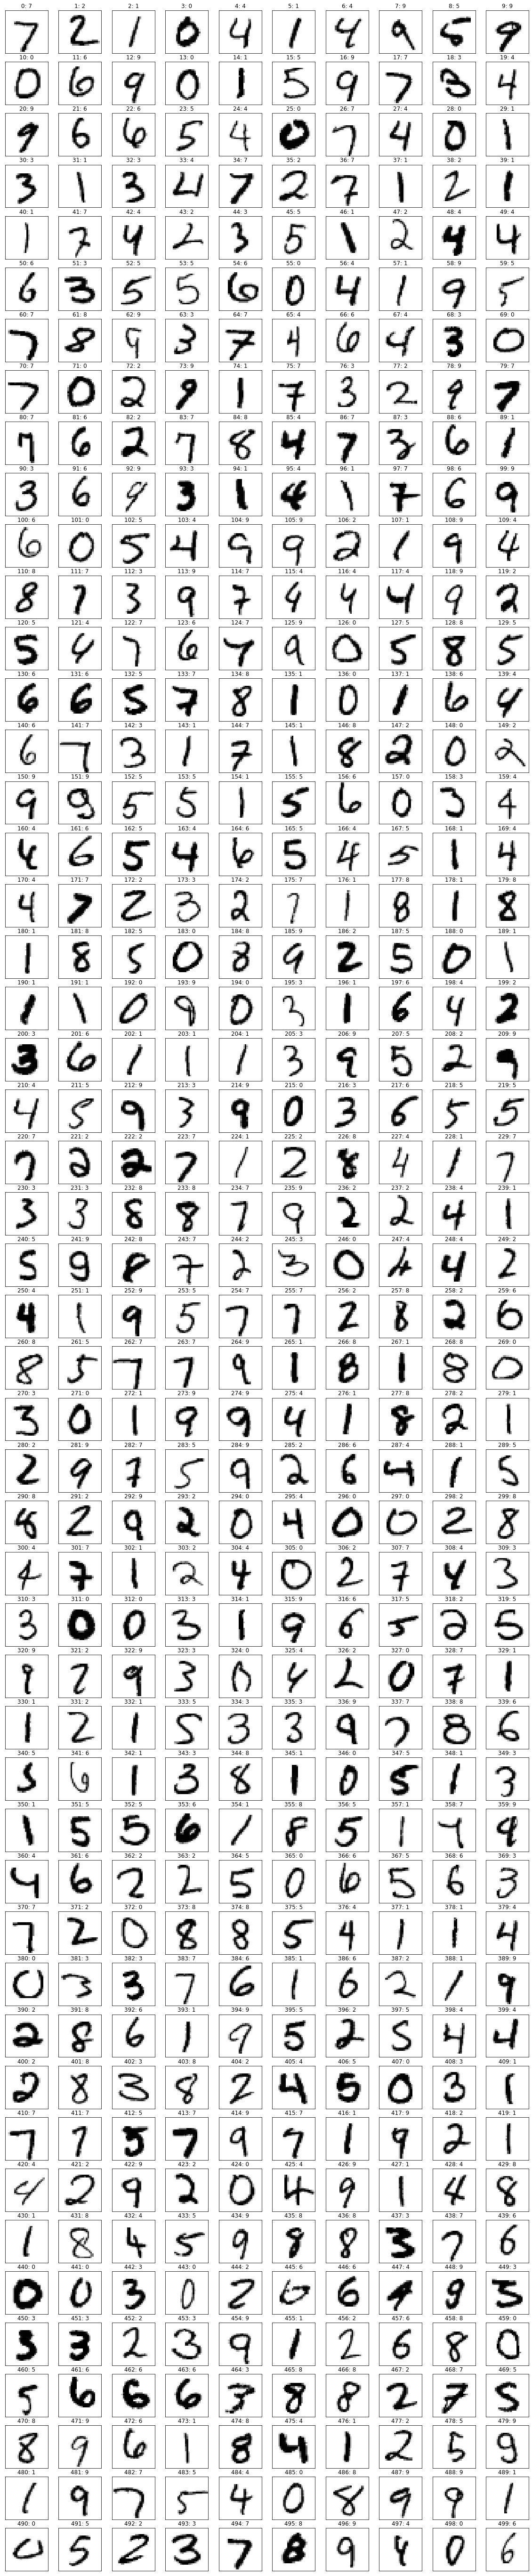

In [ ]:
print("trn:", trn_data.data.size(), trn_data.targets.size())
print("tst:", tst_data.data.size(), tst_data.targets.size())

IMAGE_SIZE  = (28,28)
NUM_CLASSES = 10

X_trn, Y_trn = trn_data.data.view((-1, 1) + IMAGE_SIZE).float()/255.,   trn_data.targets
X_tst, Y_tst = tst_data.data.view((-1, 1) + IMAGE_SIZE).float()/255.,   tst_data.targets

plt.figure(figsize=(20, 100), facecolor ='w')                  
for i in range(500):    
    ax=plt.subplot(50, 10, i+1)    
    img = X_tst[i].view( IMAGE_SIZE ).numpy()
    y   = Y_tst[i]
    plt.title(f"{i}: {y}")
    
    plt.imshow(1-img, cmap='gray')  # inverse !!!
    ticks = np.array([])
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(color='lightgray', linestyle='--', alpha=0.6)    
    #plt.axis("off")
    
plt.show()    



## Model

After the stack of cnn-layers, there is a fully connected layer with the number of outputs equal to the number of classes.<br> The dimension of its input is calculated in the constructor (`w`, `h`).

In [ ]:
class CNN(nn.Module):
    def __init__(self, 
                 shape   = (1, 64, 64),                                              # Input image shape (channels, height, width)        
                 outputs = 1,                                                        # Number of outpust 
                 channels = [], conv_kernels=[], conv_stride=1,  paddings=1, mode='replicate',      # Conv2d
                 batchnorm=False,                                                    # batchnorm
                 pool_kernel=2, pool_stride=2,  pool="max",         # Pooling
                 dropout=0.2,                                                        # Dropout
                 hiddens=None):                                                      # Add output hidden layers
        super(CNN, self).__init__()

        if paddings          == None: paddings    = 0                            # default
        if type(paddings)    == int:  paddings    = [paddings]   *len(channels)
        if conv_stride       == None: conv_stride = 1                            # default
        if type(conv_stride) == int:  conv_stride = [conv_stride]*len(channels)
        if pool_kernel       == None: pool_kernel = 2                            # default
        if type(pool_kernel) == int:  pool_kernel = [pool_kernel]*len(channels)    
        if type(pool_stride) == int:  pool_stride = [pool_stride]*len(channels)
        if not hiddens:               hiddens = []

        in_channels, h, w = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):
            if conv_kernels[i]:
                self.layers +=  [ 
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=conv_kernels[i], stride=conv_stride[i],  padding=paddings[i], padding_mode=mode),
                ]
                if batchnorm:                          # beetwen Line and non line   http://arxiv.org/pdf/1502.03167v2.pdf
                    self.layers += [ nn.BatchNorm2d(num_features=channels[i+1]) ]
                self.layers += [ nn.ReLU() ]             

                h = int( (h + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)
                w = int( (w + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)  

            print("1:", w)

            if pool_kernel[i] > 1:
                if pool == 'max': self.layers += [nn.MaxPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                else:             self.layers += [nn.AvgPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                h = int( (h - pool_kernel[i]) / pool_stride[i] + 1)
                w = int( (w - pool_kernel[i]) / pool_stride[i] + 1)

            print("2:", w)
                
        self.layers += [ nn.Flatten(1) ]

        hiddens = [channels[-1] * h * w] + hiddens + [outputs]
        for i in range( len(hiddens)-1):
            if dropout > 0:        
                self.layers += [ nn.Dropout(p=dropout) ]
        
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                              # for probability after this need sigmoid (we used BCEWithLogitsLoss)
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res

In [ ]:
CFG = {
    'input':     (1,)+IMAGE_SIZE,
    'outputs':   NUM_CLASSES,
    'channels':  [32,32,32,3],
    'kernels':   [3,3,3,3],
    'strides':   [1,1,1,1],
    'paddings':  [1,1,1,1],
    'mode':      'replicate',   #'replicate', 'zeros'
    'pool_ker':  [0,2,0,2],
    'pool_str':  [0,2,0,2],
    'batchnorm': False,
    'dropout':   0.25,
    'batch':     512,
    'lr':        5e-4,   #!!!
    'L2':        1e-4,
    'hiddens':  []       #!!!
} 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN(shape = CFG['input'], outputs = CFG['outputs'],
            channels=CFG['channels'], conv_kernels=CFG['kernels'], conv_stride=CFG['strides'],  paddings=CFG['paddings'], mode=CFG['mode'],   # Conv2d        
            pool_kernel=CFG['pool_ker'], pool_stride=CFG['pool_str'],  pool="max",                               
            batchnorm=CFG['batchnorm'],                                                    # batchnorm
            dropout = CFG['dropout'],
            hiddens = CFG['hiddens'])

out = model(X_trn[:2])
print(out.shape)

tot = 0
for k, v in model.state_dict().items():
    pars = np.prod(list(v.shape)); tot += pars
    print(f'{k:20s} :{pars:7d}  =  {tuple(v.shape)} ')
print(f"{'parameters':20s} :{tot:7d}")

model.to(device)

CFG['params'] = tot
summary(model, (1,1)+IMAGE_SIZE, col_names=["kernel_size", "output_size", "num_params"],) 


cuda:0
1: 28
2: 28
1: 28
2: 14
1: 14
2: 14
1: 14
2: 7
torch.Size([2, 10])
model.0.weight       :    288  =  (32, 1, 3, 3) 
model.0.bias         :     32  =  (32,) 
model.2.weight       :   9216  =  (32, 32, 3, 3) 
model.2.bias         :     32  =  (32,) 
model.5.weight       :   9216  =  (32, 32, 3, 3) 
model.5.bias         :     32  =  (32,) 
model.7.weight       :    864  =  (3, 32, 3, 3) 
model.7.bias         :      3  =  (3,) 
model.12.weight      :   1470  =  (10, 147) 
model.12.bias        :     10  =  (10,) 
parameters           :  21163


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
CNN                                      --                        [1, 10]                   --
├─Sequential: 1-1                        --                        [1, 10]                   --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         --                        [1, 32, 28, 28]           --
│    └─Conv2d: 2-3                       [3, 3]                    [1, 32, 28, 28]           9,248
│    └─ReLU: 2-4                         --                        [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-5                    2                         [1, 32, 14, 14]           --
│    └─Conv2d: 2-6                       [3, 3]                    [1, 32, 14, 14]           9,248
│    └─ReLU: 2-7                         --                        [1, 32, 14, 14]           --
│    └─Conv2d: 2-8          

## Network learning

It is better to put all the training data in GPU memory. So it will be faster. However, with a large number of examples, memory may not be enough. Therefore, each batch is sent to memory.

In [ ]:
def fit(model, X,Y, batch_size=64, train=True, calc_L2 = False):         
    """ One epoch training """
    batch_size = min(batch_size, len(X))
    losses, accs = [], []
       
    idx = torch.randperm( len(X) )                      # permuted index list    
    X, Y = X[idx], Y[idx]      
    
    L2 = sum(p.data.pow(2).sum() for p in model.parameters()).cpu().item() if calc_L2 else -1
    
    model.train(train)                                  # important for Dropout, BatchNorm layers
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device) 
              
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss
  
        if train:                                       # we are in learning mode
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters
                                     
        losses.append(L.cpu().item())                   # total loss (item from graph)
        
        a = y.detach().argmax(axis=1)                   
        accs.append( (a == yb).float().mean().cpu().item() )  # class definition accuracy
         
    return np.mean(losses),  np.mean(accs), L2          # mean loss and accuracy

def smooth(x, beta=0.75):    
    av = np.copy(x)
    for i in range(1, len(x)):                
        av[i] = beta*av[i-1]+(1-beta)*x[i]        
    return av
    #return  np.convolve(x, np.ones(n)/n, mode='same')

def plot_train(history, alpha=0.3):
    """ Plot loss and accuarcy: history = [epoch, L_trn, L_tst, L2, A_trn, A_tst] """
    h = np.array(history)                               # learning output
    plt.figure(figsize=(16,5), facecolor ='w')              
    ax = plt.subplot(1, 2, 1);  
    plt.xlabel('epoch');  plt.ylabel('loss');  ax.set_title(f"loss_trn: {h[-1,1]:.4f}, loss_tst: {h[-1,2]:.4f}")
    ax.set( ylim=(0, 0.5), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 1]), "-b")
    plt.plot(h[:,0], smooth(h[:, 2]), "-g")        
    ax.legend(['loss trn', 'loss tst'], loc='lower left')
    plt.plot(h[:,0], h[:, 1], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 2], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    ax2=ax.twinx()  
    ax2.plot(h[:,0], h[:,3], ":r"); ax2.set_ylabel('L2');   
    ax2.legend(['L2'], loc='center right')

    ax = plt.subplot(1, 2, 2);      
    plt.xlabel('epoch'); plt.ylabel('accuracy');  ax.set_title(f"acc_trn: {h[-1,4]:.4f}, acc_tst: {h[-1,5]:.4f}")
    ax.set( ylim=(0.5, 1.0), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 4]), "-b")
    plt.plot(h[:,0], smooth(h[:, 5]), "-g")
    ax.legend( ['acc trn', 'acc tst'], loc='lower left' )
    plt.plot(h[:,0], h[:, 4], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 5], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    
    pars = [ f"{k:10s}: {v}\n" for k,v in CFG.items() ]
    ax.text(h[0,0]+(h[-1,0]-h[0,0])*0.5, 0.5, "".join(pars), {'fontsize':10, 'fontname':'monospace'})
    plt.show()

## Run training

before:      loss: 2.304352 accuracy: 0.097552
epoch:   100 loss: 0.043475 (0.028079) L2: 158.542221 accuracy: 0.985854 (0.991908)  31.90s

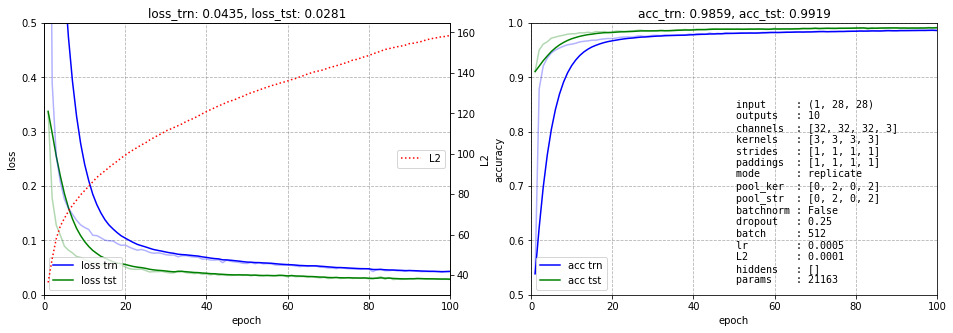

epoch:   200 loss: 0.028547 (0.025591) L2: 196.637512 accuracy: 0.990775 (0.992168)  31.69s

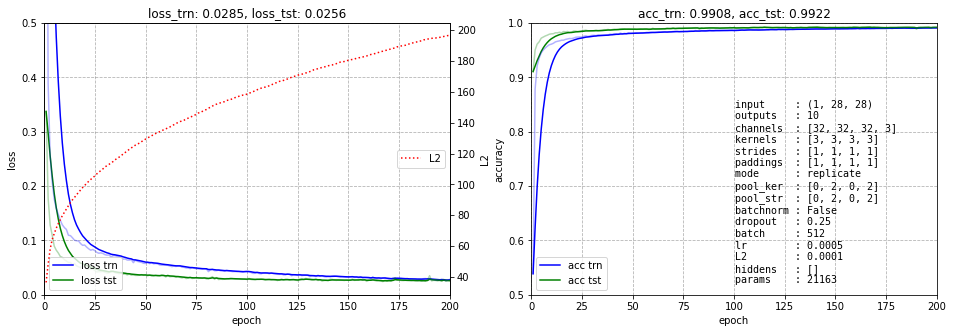

epoch:   270 loss: 0.022326 (0.024080) L2: 214.737686 accuracy: 0.992552 (0.991980)  31.63s

KeyboardInterrupt: ignored

In [ ]:
torch.cuda.empty_cache()

loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['L2'])   

epochs = 2000

model.to(device) # just in case
L_tst, A_tst, _ = fit(model, X_trn,Y_trn, batch_size=2048, train=False)
print( "before:      loss: %8.6f accuracy: %.6f" % (L_tst, A_tst)  )

history, losses, accs, beg = [], [], [], time.process_time()
for epoch in range(1, epochs+1):   
    
    L, A, L2 = fit(model, X_trn, Y_trn, batch_size=CFG['batch'], calc_L2=True)     # one epoch
    losses.append(L); accs.append(A)    

    if epoch % 1 == 0 or epoch == epochs:              # learning output   
        L_tst, A_tst, _ = fit(model, X_tst, Y_tst, batch_size=2048, train=False) 

    if epoch % 10 == 0:                                # learning output   
        print(f"\repoch: {epoch:5d} loss: {L:8.6f} ({L_tst:8.6f}) L2: {L2:.6f} accuracy: {A:.6f} ({A_tst:.6f})  {time.process_time()-beg:.2f}s", end="")           
        beg = time.process_time()                

    history.append([epoch, L, L_tst, L2, A, A_tst])

    if epoch % 100  == 0:
        plot_train(history)
                
plot_train(history)

## Plot wrong tests

91 0.9909
[ 445  450  582  674  684  689  726  829  846  947 1014 1039 1112 1114
 1178 1182 1226 1232 1242 1247 1260 1364 1393 1522 1621 1641 1709 1721
 1901 1911 1982 2035 2043 2070 2109 2130 2148 2182 2185 2414 2447 2462
 2480 2597 2654 2823 2995 3005 3073 3225 3288 3316 3422 3503 3520 3534
 3601 3767 3808 3853 4007 4497 4571 4740 4783 4823 4860 5736 5937 5955
 6065 6555 6571 6572 6576 6597 6625 6651 6783 7434 8316 8376 9015 9530
 9620 9621 9679 9729 9768 9779 9904]
91


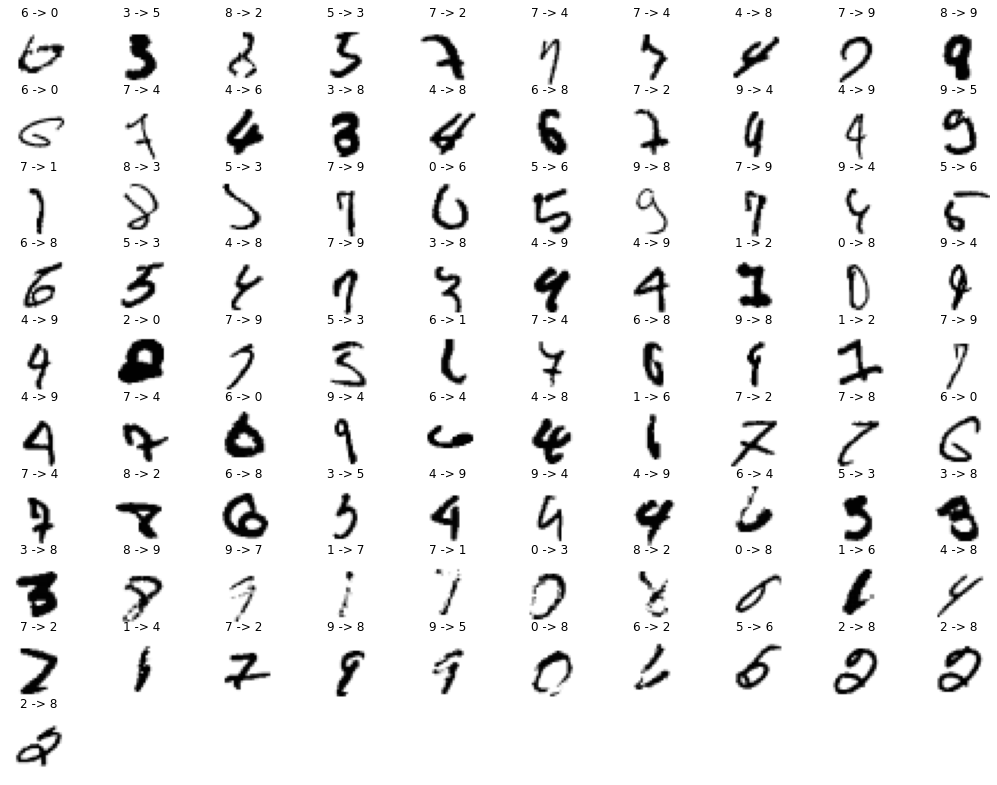

In [ ]:
def get_wrong(model, X,Y, batch_size=100):            
    batch_size = min(batch_size, len(X))      
    model.train(False)                                 # important for Dropout, BatchNorm layers
    wrong   = torch.tensor([], dtype=torch.int64)
    classes = torch.tensor([], dtype=torch.int64)    
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                     # current batch                
        yb = Y[i: i+nb].to(device)               

        y = model(xb)                                   # forward propagation         
        L = loss(y, yb) 
                
        a = y.argmax(axis=1)                
        
        classes = torch.cat([classes, a.cpu()], axis=0)        
        wrong   = torch.cat(  [wrong, i + (a != yb).cpu().nonzero(as_tuple=True)[0] ], axis=0  ) 
        
    return wrong.numpy(), classes.numpy()       # mean loss, accuracy, errosrs

wrong, classes = get_wrong(model, X_tst,Y_tst, 128)
print(len(wrong), 1-len(wrong)/len(Y_tst))

print(wrong)

count = min(200,len(wrong))
print(count)
plt.figure(figsize=(18,28))         
for i in range(count):    
    plt.subplot(20, 10, i+1)    
    plt.title(f"{Y_tst[wrong[i]]} -> {classes[wrong[i]]}")
    img = X_tst[wrong[i]].view(IMAGE_SIZE).numpy()
    plt.imshow( 1-img , cmap='gray')
    plt.axis('off')
plt.show()    


## Confusion matrix

total accuracy: 0.9909
classes accuracy: [0.99489796 0.99471366 0.99612403 0.99405941 0.98676171 0.99103139
 0.9874739  0.98054475 0.99383984 0.98909812]


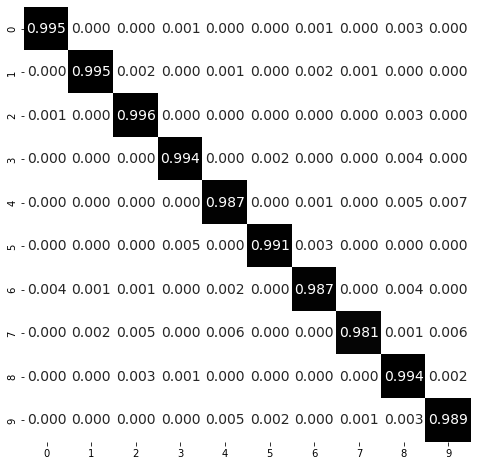

In [ ]:
from   sklearn.metrics import confusion_matrix
import seaborn as sn

matrix = confusion_matrix(Y_tst.numpy(), classes )

print("total accuracy:", matrix.diagonal().sum()/matrix.sum())
print("classes accuracy:", matrix.diagonal()/matrix.sum(axis=1))

matrix = matrix / matrix.sum(axis=1)
plt.figure(figsize = (8,8))
sn.heatmap(matrix, annot=True, cmap="Greys", annot_kws={"size": 14}, fmt=".3f", cbar=False)
plt.show()

## Feature maps

(10, 1, 28, 28)


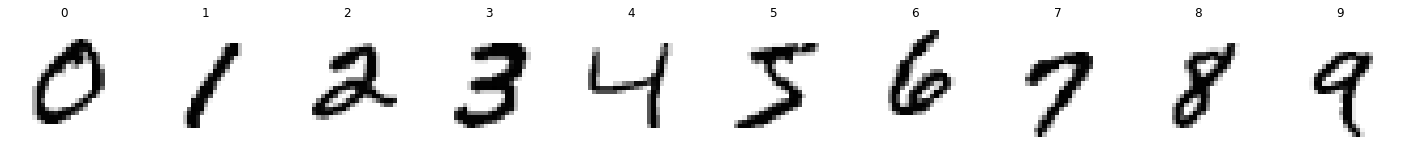

In [ ]:
N_images = NUM_CLASSES

X = []
for i in range(10):
    sel = X_trn[Y_trn==i]
    X.append( sel[0].numpy() )    
X = np.array(X)    
print(X.shape)

inp  = torch.tensor(X, dtype=torch.float32)  # channel first

plt.figure(figsize=(25, 5))                   # plot the 16 examples
for lv in range(1):
    for i in range(10):    
        plt.subplot(1, 10, i+1)    
        plt.title(f"{i} ")
        img = X[i].reshape(IMAGE_SIZE)
        plt.imshow(1-img, cmap="gray")
        plt.axis('off')
plt.show()    

CNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (6): ReLU()
    (7): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=147, out_features=10, bias=True)
  )
)
plottingx
(10, 3, 7, 7)


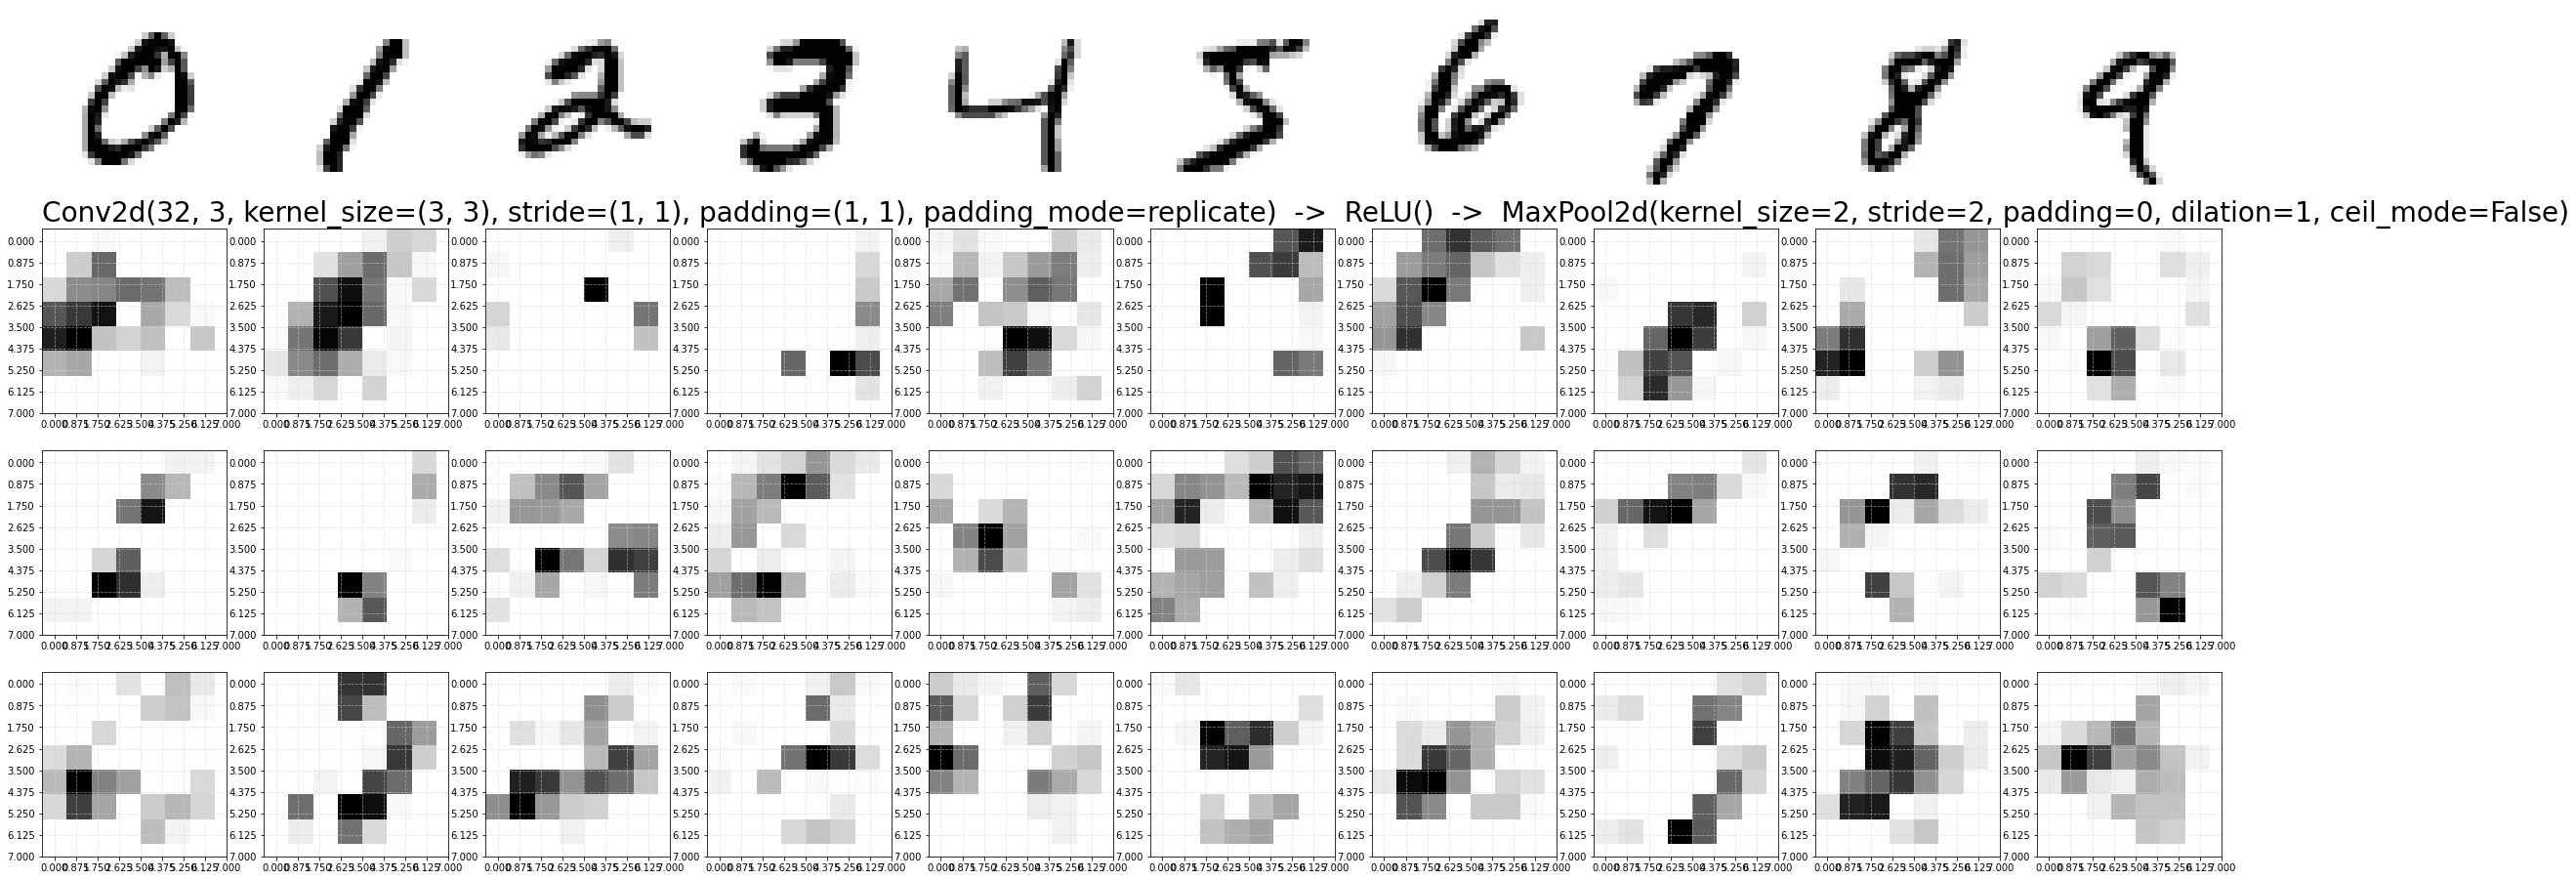

In [ ]:
print(model)
layers = model.get(inp.to(device))
print("plottingx")
layerID = [9]

num = 0
for i in range(len(layerID)):     # by layer
    layer = layers[layerID[i]]
    num += layer.shape[1]
    print(layer.shape)

tot = 1
plt.figure(figsize=(4*N_images, 4*(num+1)), facecolor ='w') 

for k in range(N_images):        # by image            
    plt.subplot(num+1, N_images, tot)        
    tot += 1            
    plt.imshow(1-X[k].reshape(IMAGE_SIZE), cmap="gray")
    plt.axis('off')

for i in range(len(layerID)):                # by layer
    layer = layers[layerID[i]]        
    for j in range(layer.shape[1]):          # by channel
        for k in range(N_images):        # by image
            ax = plt.subplot(num+1, N_images, tot)    
            tot += 1            
            if k == 0 and j == 0:
                plt.title(str(model.layers[layerID[i]-2]) + "  ->  " + str(model.layers[layerID[i]-1]) + "  ->  "+  str(model.layers[layerID[i]]), loc="left", fontsize=28)
            
            img = layer[k,j]
            plt.imshow(img.max()-img, cmap="gray", vmin = img.min(), vmax = img.max())  # "bwr"
            #ax.set( xlim=(0, img.shape[0]), ylim=(0, img.shape[1]) )
            ax.set_xticks(np.linspace(0, img.shape[0], 9 ))
            ax.set_yticks(np.linspace(0, img.shape[1], 9 ))
            ax.grid(color='lightgray', linestyle='--', alpha=0.6)
            

plt.show()   
